# ITCR - Escuela de Computación
### Aprendizaje profundo
### Redes Neuronales Convolucionales (CNN)

### Tarea 3

### Estudiante: Ricardo Jose Chacon Brenes


In [2]:
# bibliotecas requeridas 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import zipfile
from torchvision.datasets import ImageFolder
from PIL import Image
from collections import Counter
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler



# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model evaluation
from sklearn import metrics

# Ejercicio 1 - CNN.

1. Describa el problema y el objetivo del ejercicio.

### Descripción del problema:
El problema se trata de un ejercicio de clasificación de imágenes utilizando redes neuronales convolucionales (CNN). Se tienen fotos de personas con diferentes expresiones faciales, incluyendo enojadas, tristes y felices. El objetivo es desarrollar un modelo de aprendizaje automático que pueda analizar estas imágenes y clasificar correctamente la emoción que representa cada una.

### Objetivo del ejercicio:
El objetivo principal es entrenar un modelo de redes neuronales convolucionales capaz de clasificar las imágenes de personas enojadas, tristes y felices con alta precisión. Al utilizar una CNN, el modelo deberá ser capaz de aprender patrones y características relevantes presentes en las imágenes para distinguir las diferentes expresiones faciales.


2. Seleccione uno de los conjuntos de datos (listados al final) y referencie formalmente los
datos que utilizará en el ejercicio.

Se seleccionó el conjunto de datos 'Human Face Emotions' debido a su relevancia y utilidad en el análisis de expresiones faciales humanas. Este conjunto de datos contiene una amplia variedad de imágenes que capturan diferentes emociones faciales, lo que permite llevar a cabo investigaciones y desarrollos relacionados con el reconocimiento emocional y la inteligencia artificial. Los datos se obtuvieron de Kaggle, una plataforma reconocida por su riqueza en recursos y comunidades de ciencia de datos. Para acceder a los datos, se utilizó el siguiente enlace oficial: https://www.kaggle.com/datasets/sanidhyak/human-face-emotions.

In [3]:
# Cargue, escale y explore los datos. Utilice las clases Datasets y DataLoader para acceder al conjunto de datos de imágenes.


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
EMOTIONS = {
    0: "angry",
    1: "happy",
    2: "sad"
}

In [5]:
# Importar el folder 'data'
folder = r'C:\Users\chaconri\Desktop\Data Science TEC\data'
emotions = ["Angry", "Happy", "Sad"]

X = []
y = []
# Setting image to this size
image_size = (128, 128)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

for idx, emotion in enumerate(emotions):
    emotion_folder = os.path.join(folder, emotion)
    for image_file in os.listdir(emotion_folder):
        image_path = os.path.join(emotion_folder, image_file)
        try:
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image)
            X.append(image_tensor)
            y.append(idx)
        except Exception as e:
            print(f"Error loading image: {image_path}. Error: {e}")

X = torch.stack(X)
y = torch.tensor(y)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = X.to(device)
y = y.to(device)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: torch.Size([265, 3, 128, 128])
Shape of y: torch.Size([265])


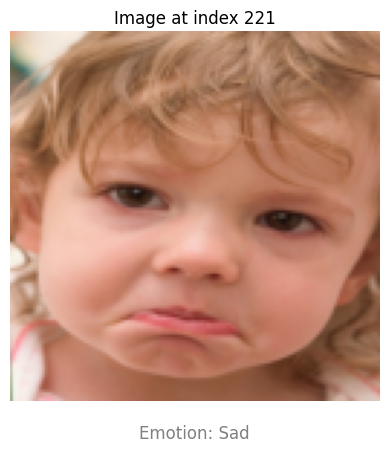

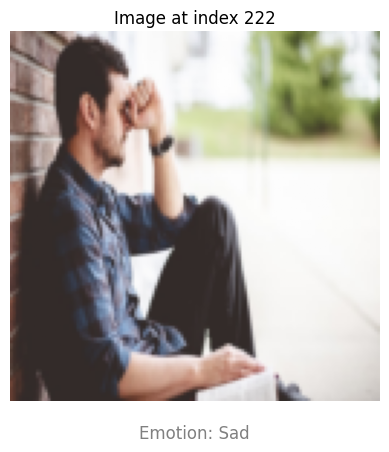

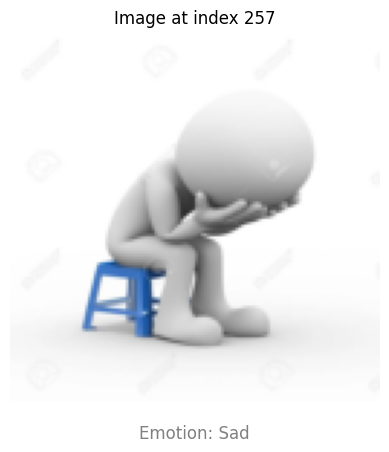

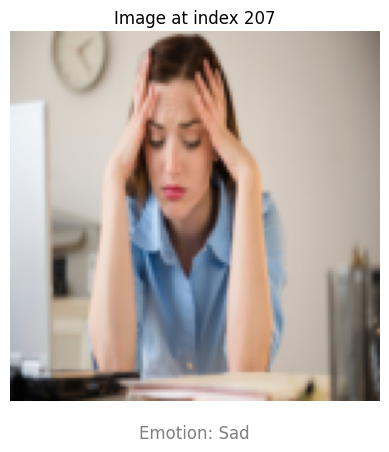

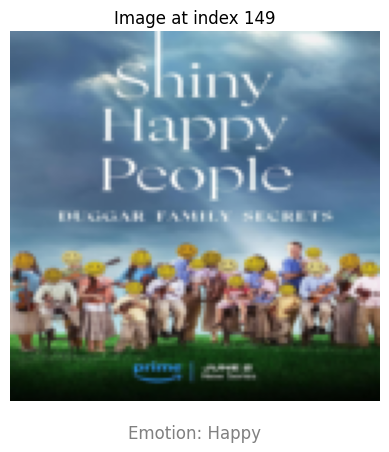

In [6]:
import random

for i in range(5):
  random_idx = random.randint(0, X.shape[0] - 1)
  emotion_idx = y[random_idx].item()

  image_tensor = X[random_idx].cpu()

  image_np = image_tensor.permute(1, 2, 0).numpy()

  plt.imshow(image_np)
  plt.title(f"Image at index {random_idx}")
  plt.axis('off')
  plt.text(0.5, -0.1, f"Emotion: {emotions[emotion_idx]}", transform=plt.gca().transAxes, ha='center', fontsize=12, color='gray')
  plt.show()

In [7]:
# Cantidad de lables en el data set de human face emotions

y_list = y.cpu().tolist()
label_counter = Counter(y_list)

for i in label_counter:
    print("Emotion:", EMOTIONS.get(i), "| Count:", label_counter[i])

Emotion: angry | Count: 86
Emotion: happy | Count: 100
Emotion: sad | Count: 79


In [8]:
#  Datos de Entrenamiento y Validación
BATCH_SIZE = 32
NUM_EPOCHS = int(5e2)
LEARNING_RATE = 1e-3

dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# Definicion de red convulcional

class EmotionsModel(nn.Module):
    def __init__(self):
        super(EmotionsModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(128, 3),  # 3 classes: Angry, Happy, Sad
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [13]:
# Etrenamiento del modelo

Model = EmotionsModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=LEARNING_RATE)


print_epochs = [1, 10, 50, 100, 250, 500, 750]
loss_values = []

# Training loop
for epoch in range(NUM_EPOCHS):
    Model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = Model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    loss_values.append(train_loss)

    if (epoch + 1) in print_epochs:
        print(f"Epoch: [{epoch+1}/{NUM_EPOCHS}] | Loss: {train_loss:.4f}")

Epoch: [1/500] | Loss: 2.2373
Epoch: [10/500] | Loss: 0.8287
Epoch: [50/500] | Loss: 0.0687
Epoch: [100/500] | Loss: 0.0150
Epoch: [250/500] | Loss: 0.0015
Epoch: [500/500] | Loss: 0.0010


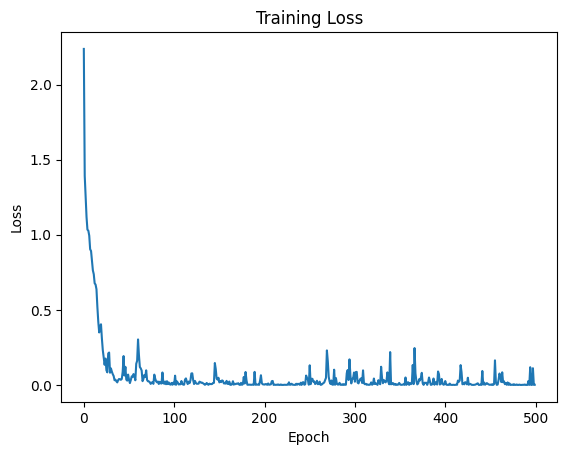

In [14]:
 # 10. Visualice la curva de error e interprete los resultados.

import matplotlib.pyplot as plt

# Graficar la curva de pérdida
plt.plot(range(NUM_EPOCHS), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


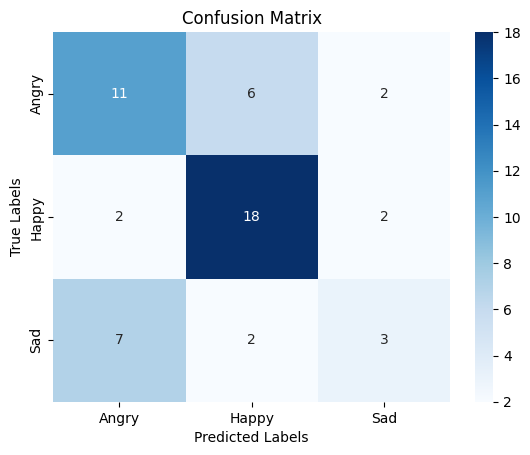

              precision    recall  f1-score   support

       Angry       0.55      0.58      0.56        19
       Happy       0.69      0.82      0.75        22
         Sad       0.43      0.25      0.32        12

    accuracy                           0.60        53
   macro avg       0.56      0.55      0.54        53
weighted avg       0.58      0.60      0.59        53



In [21]:
# Evaluar performance
#Matriz de confusion


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


Model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = Model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_predictions)

classes = ['Angry', 'Happy', 'Sad']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_predictions, target_names=classes))



# Concluciones

El rendimiento para la clase "Happy" es el mejor: El modelo tiene un mejor desempeño al predecir la clase "Happy" con una precisión de 0.69 y un recall de 0.82, indicando que el modelo es relativamente bueno en identificar y clasificar correctamente las instancias de esta clase.

La clase "Sad" tiene el peor rendimiento: La clase "Sad" es la que el modelo predice con menor precisión. Con un recall de solo 0.25, significa que el modelo solo puede identificar correctamente el 25% de las instancias totales de "Sad", indicando un alto número de falsos negativos para esta clase. Este puede ser un problema significativo dependiendo del contexto de la tarea de predicción.

Rendimiento desequilibrado entre las clases: Existe un desequilibrio significativo en el rendimiento del modelo entre las diferentes clases. La capacidad del modelo para predecir "Angry" es promedio, pero es mejor para predecir "Happy" y menos exitoso para predecir "Sad". Esto podría indicar un problema de desequilibrio de clases en los datos de entrenamiento o la incapacidad del modelo para generalizar bien para todas las clases.

Precisión general: El modelo tiene una precisión general del 60%. Dependiendo del contexto y los requisitos de tu tarea, esto podría ser o no aceptable. Si se necesita una mayor precisión, el rendimiento del modelo podría mejorar ajustando la arquitectura del modelo, cambiando la tasa de aprendizaje, o agregando más datos de entrenamiento, especialmente para la clase "Sad", que actualmente tiene un recall bajo.
